In [347]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf
import  matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.tree import DecisionTreeClassifier


In [348]:
df = pd.read_csv("../BTC_1_year_data.csv").set_index("close_time")
df

,open,high,low,close,volume
close_time,,,,,
2024-11-30 15:29:59.999000+00:00,96602.51,96659.50,96532.00,96659.50,133.45453
2024-11-30 15:44:59.999000+00:00,96659.49,96691.69,96602.01,96634.28,117.43398
2024-11-30 15:59:59.999000+00:00,96634.28,96732.15,96602.67,96645.41,85.14427
2024-11-30 16:14:59.999000+00:00,96645.42,96757.06,96615.52,96652.01,106.03529
2024-11-30 16:29:59.999000+00:00,96652.00,96652.01,96542.70,96555.42,241.85001
...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655


#### Feature Engineering

In [349]:
df["close_log_return"] = np.log(df["close"]/df["close"].shift())

    Create lagged features

In [350]:
df = df.copy()

In [351]:
def generate_ma_features(df, close_col="close", windows=[5, 10], shift_pct=True):
    """
    Generate moving average and pct-change-to-close features for a list of window sizes.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with at least a 'close' column.
    close_col : str
        Column name for the close price.
    windows : list
        List of integers for rolling windows.
    shift_pct : bool
        Whether to shift pct-change features by 1 step to avoid leakage.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with new features added.
    """
    df = df.copy()

    for w in windows:
        ma_col = f"{w}ma"
        pct_col = f"pct_change_{w}ma_close"

        # Moving average
        df[ma_col] = df[close_col].rolling(w).mean()

        # Percentage difference from MA
        df[pct_col] = (df[close_col] - df[ma_col]) / df[ma_col] * 100

        # Shift to avoid leakage (optional)
        if shift_pct:
            df[pct_col] = df[pct_col].shift()

    return df


windows = [10, 50,200]

df = generate_ma_features(df, windows=windows)


In [352]:
df["close_log_return_lag_1"] = df["close_log_return"].shift()
df["close_log_return_lag_2"] = df["close_log_return"].shift(2)
df["close_log_return_lag_3"] = df["close_log_return"].shift(3)

In [353]:
df = df.dropna(how="any")

    Create binary classification target
        - 1=> Long => Price moves up
        - 0=> Short => Price goes down

In [354]:
df["close_log_return_dir"] = df["close_log_return"].map(lambda x:1 if x>0 else 0)
# df = df.drop(columns="close_log_return")

In [355]:
df

,open,high,low,close,volume,close_log_return,10ma,pct_change_10ma_close,50ma,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
close_time,,,,,,,,,,,,,,,,
2024-12-02 17:29:59.999000+00:00,96263.99,96324.00,95372.72,95372.73,697.37610,-0.009302,96538.085,-0.381805,95839.3012,0.415145,96638.00240,-0.393656,0.001003,-0.002374,-0.002114,0
2024-12-02 17:44:59.999000+00:00,95372.73,95498.87,95051.11,95450.00,1061.30282,0.000810,96439.485,-1.207145,95810.6534,-0.486827,96632.08100,-1.309291,-0.009302,0.001003,-0.002374,1
2024-12-02 17:59:59.999000+00:00,95450.00,95460.00,94395.00,94604.03,954.78259,-0.008902,96232.862,-1.026016,95768.7340,-0.376423,96621.87410,-1.223280,0.000810,-0.009302,0.001003,0
2024-12-02 18:14:59.999000+00:00,94604.03,95396.00,94488.00,95367.99,846.79767,0.008043,96053.661,-1.692594,95745.1934,-1.216163,96615.45400,-2.088393,-0.008902,0.000810,-0.009302,1
2024-12-02 18:29:59.999000+00:00,95368.00,95599.00,95235.99,95515.42,315.32601,0.001545,95900.403,-0.713842,95728.3020,-0.393966,96610.25400,-1.291164,0.008043,-0.008902,0.000810,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,91770.00,91779.94,91641.05,91682.73,57.57016,-0.000951,91492.959,0.362326,91108.4782,0.741975,90973.87660,0.876005,0.000886,-0.001771,0.004175,0
2025-11-30 14:29:59.999000+00:00,91682.74,91707.30,91483.61,91554.20,117.52310,-0.001403,91543.501,0.207416,91121.2960,0.630295,90973.85595,0.779183,-0.000951,0.000886,-0.001771,0
2025-11-30 14:44:59.999000+00:00,91554.19,91583.61,91256.88,91359.92,236.73655,-0.002124,91555.036,0.011687,91129.5986,0.475085,90973.25385,0.637924,-0.001403,-0.000951,0.000886,0


In [356]:
df_temp = pd.DataFrame(columns=["close_log_return", "close"])
df_temp[["close_log_return", "close"]] = df[["close_log_return", "close"]]

In [357]:
def drop_ma_columns(df, windows, extra_drop=None):
    """
    Remove moving-average columns after pct-change features are created.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    windows : list
        List of MA windows used (e.g., [5,10,20]).
    extra_drop : list or None
        Additional columns to drop explicitly.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with MA columns removed.
    """
    df = df.copy()

    # ma columns generated earlier
    ma_cols = [f"{w}ma" for w in windows]

    # combine with user-provided columns
    if extra_drop:
        drop_cols = list(set(ma_cols + extra_drop))
    else:
        drop_cols = ma_cols

    # drop only those that actually exist
    drop_cols = [c for c in drop_cols if c in df.columns]

    df = df.drop(columns=drop_cols, errors="ignore")

    return df


df = drop_ma_columns(
    df,
    windows,
    extra_drop=["volume", "close_log_return", "open", "high", "low", "close"],
)

In [358]:
def plot_feature_scatter(df, sample_size=2000):
    """
    Creates a scatter plot matrix (pairplot) for all features in df.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing numerical features.
    sample_size : int
        Optional sampling to speed up plotting (very important for large datasets).
    """
    
    # Use only numeric columns
    numeric_df = df.select_dtypes(include=["number"]).copy()

    # Optional sampling for speed
    if len(numeric_df) > sample_size:
        numeric_df = numeric_df.sample(sample_size, random_state=42)

    sns.pairplot(numeric_df, diag_kind="kde")
    plt.show()


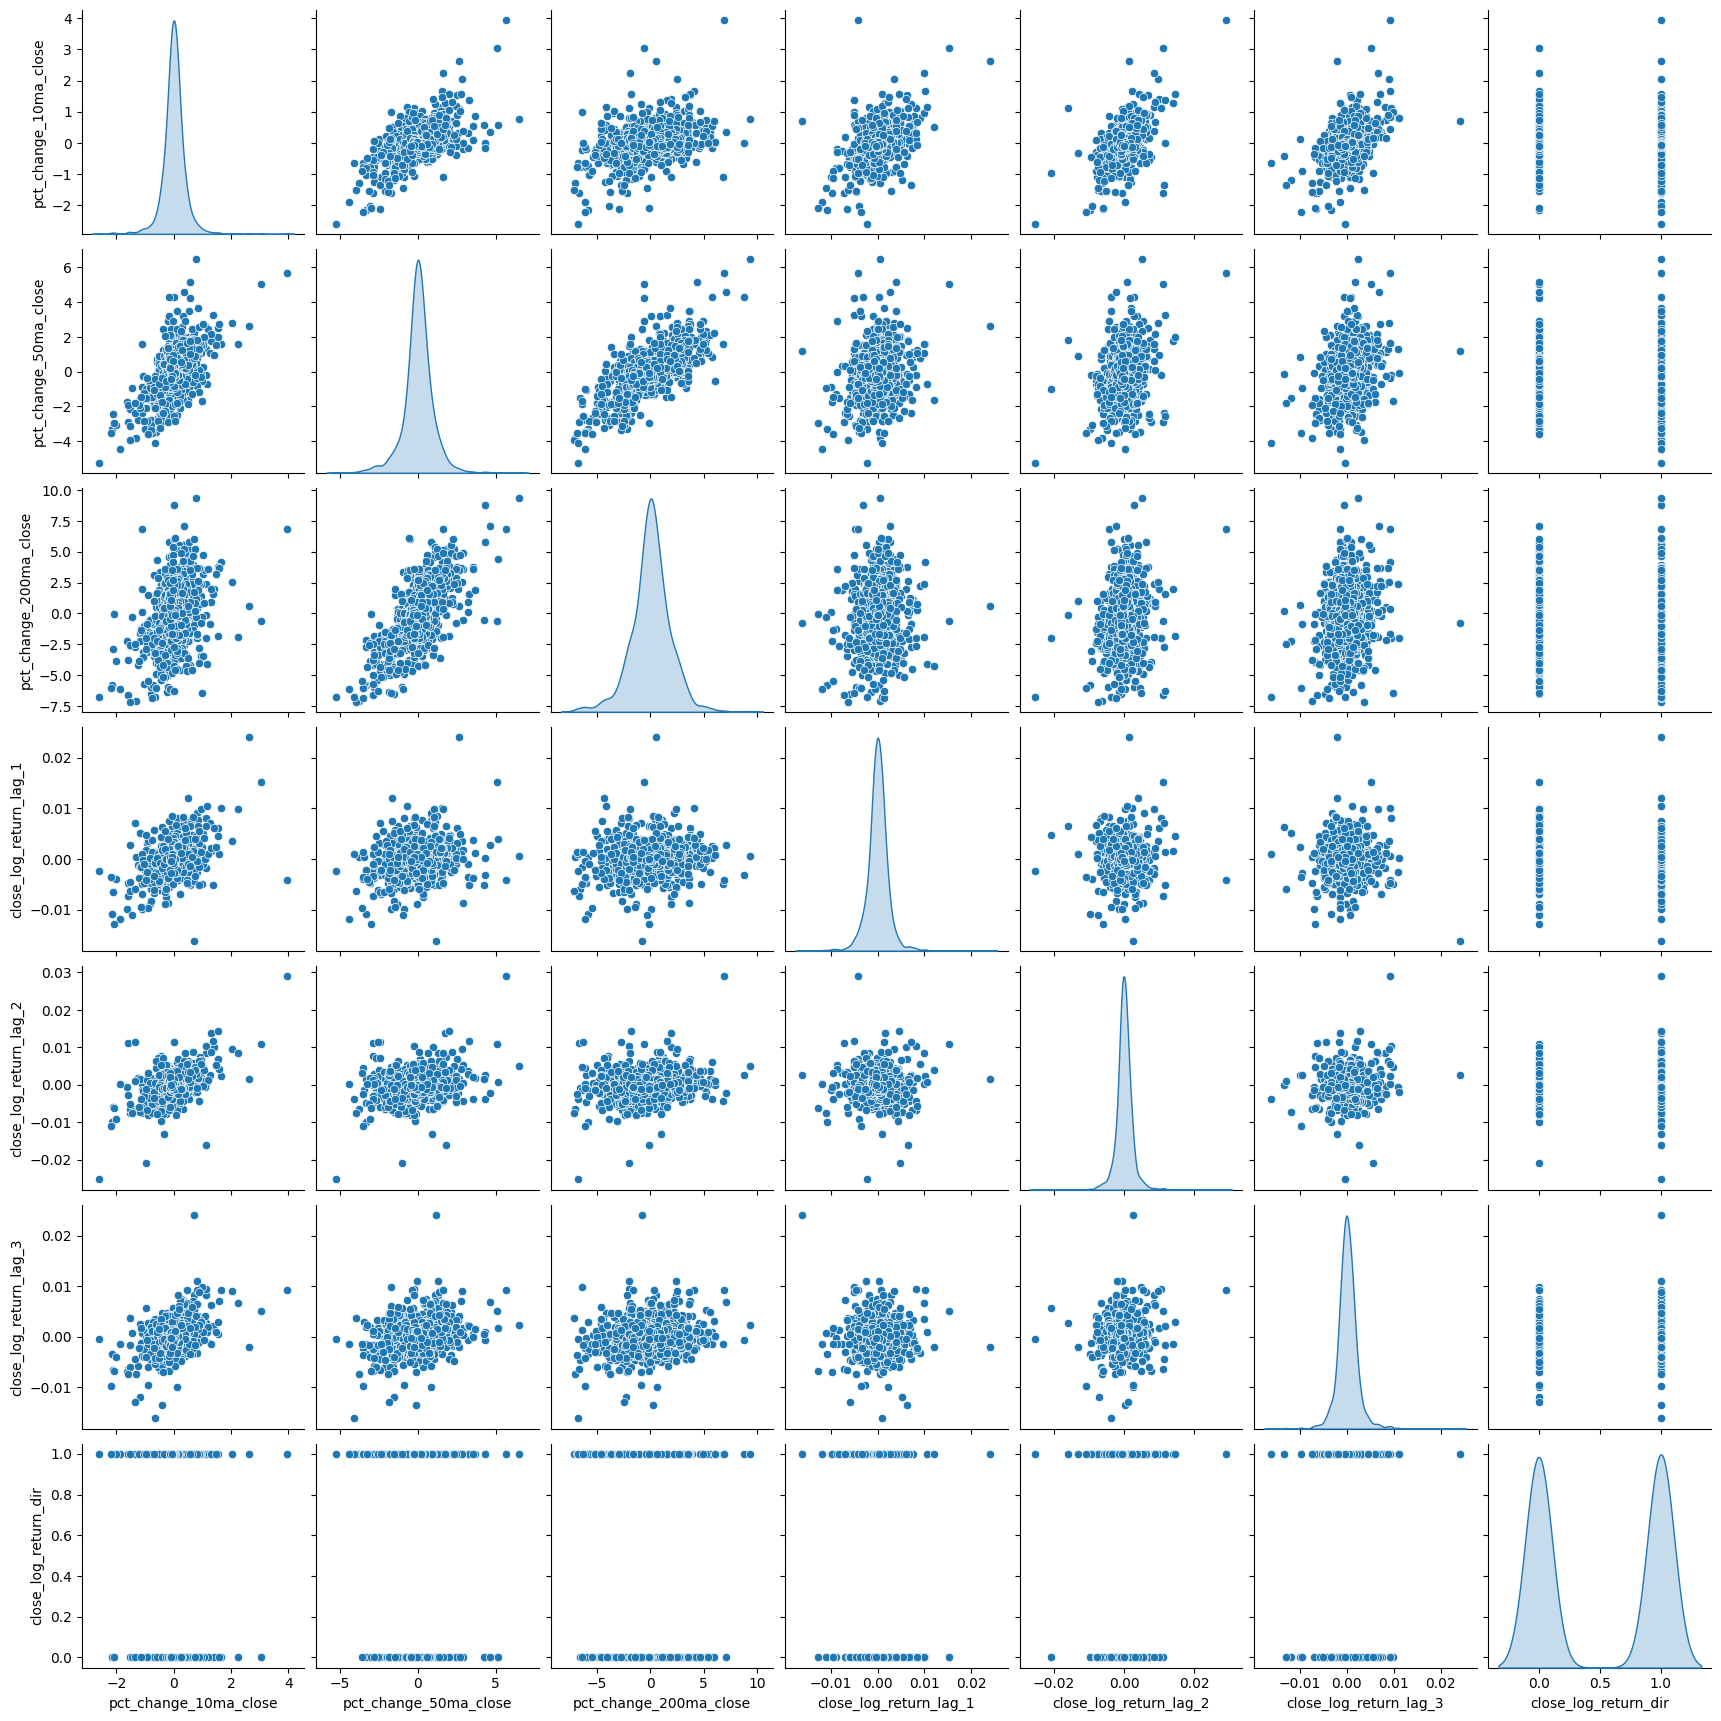

In [359]:
plot_feature_scatter(df)


In [360]:
df.head()

,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
close_time,,,,,,,
2024-12-02 17:29:59.999000+00:00,-0.381805,0.415145,-0.393656,0.001003,-0.002374,-0.002114,0
2024-12-02 17:44:59.999000+00:00,-1.207145,-0.486827,-1.309291,-0.009302,0.001003,-0.002374,1
2024-12-02 17:59:59.999000+00:00,-1.026016,-0.376423,-1.223280,0.000810,-0.009302,0.001003,0
2024-12-02 18:14:59.999000+00:00,-1.692594,-1.216163,-2.088393,-0.008902,0.000810,-0.009302,1
2024-12-02 18:29:59.999000+00:00,-0.713842,-0.393966,-1.291164,0.008043,-0.008902,0.000810,1


    Check class imbalance

In [361]:
print(df["close_log_return_dir"].value_counts())

close_log_return_dir
0    17459
1    17381
Name: count, dtype: int64


#### Split data into training and testing set but in temporal order

    Feature-Target Split

In [362]:
X = df.iloc[:,:-1 ]
y = df.iloc[:,-1]

In [363]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test=train_test_split(X_test,y_test, test_size=0.2, shuffle=False)

In [364]:
df_temp["close_log_return"]

close_time
2024-12-02 17:29:59.999000+00:00   -0.009302
2024-12-02 17:44:59.999000+00:00    0.000810
2024-12-02 17:59:59.999000+00:00   -0.008902
2024-12-02 18:14:59.999000+00:00    0.008043
2024-12-02 18:29:59.999000+00:00    0.001545
                                      ...   
2025-11-30 14:14:59.999000+00:00   -0.000951
2025-11-30 14:29:59.999000+00:00   -0.001403
2025-11-30 14:44:59.999000+00:00   -0.002124
2025-11-30 14:59:59.999000+00:00    0.001532
2025-11-30 15:14:59.999000+00:00   -0.000650
Name: close_log_return, Length: 34840, dtype: float64

In [365]:
def time_split(x, train_size=0.8):
    i = int(len(x) * train_size)
    return x[:i].copy(), x[i:].copy()


df_train_temp, df_test_temp = time_split(df_temp, train_size=0.8)

In [366]:
print(y_train.value_counts())
print(y_test.value_counts())

close_log_return_dir
0    10480
1    10424
Name: count, dtype: int64
close_log_return_dir
0    1403
1    1385
Name: count, dtype: int64


### Scikit-learn Cecision Tree Model

In [367]:
model = DecisionTreeClassifier(max_depth=3)

In [368]:
model.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [369]:
accuracy_score(y_train, model.predict(X_train))

0.5281285878300803

In [370]:
accuracy_score(y_test, model.predict(X_test))


0.5211621233859397

In [371]:
cm = confusion_matrix(y_test, model.predict(X_test))

#### Hyperparameter Tuning

In [372]:
depth_hyperparams = range(1,50,2)

In [373]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(random_state=42, max_depth=d)
        
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

    print("Training Accuracy Scores:", training_acc[:3])
    print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.5203788748564868]
Validation Accuracy Scores: [0.5088805166846071]
Training Accuracy Scores: [0.5203788748564868, 0.5281285878300803]
Validation Accuracy Scores: [0.5088805166846071, 0.5106745604592752]
Training Accuracy Scores: [0.5203788748564868, 0.5281285878300803, 0.538222349789514]
Validation Accuracy Scores: [0.5088805166846071, 0.5106745604592752, 0.5108539648367421]
Training Accuracy Scores: [0.5203788748564868, 0.5281285878300803, 0.538222349789514]
Validation Accuracy Scores: [0.5088805166846071, 0.5106745604592752, 0.5108539648367421]
Training Accuracy Scores: [0.5203788748564868, 0.5281285878300803, 0.538222349789514]
Validation Accuracy Scores: [0.5088805166846071, 0.5106745604592752, 0.5108539648367421]
Training Accuracy Scores: [0.5203788748564868, 0.5281285878300803, 0.538222349789514]
Validation Accuracy Scores: [0.5088805166846071, 0.5106745604592752, 0.5108539648367421]
Training Accuracy Scores: [0.5203788748564868, 0.5281285878300803, 0

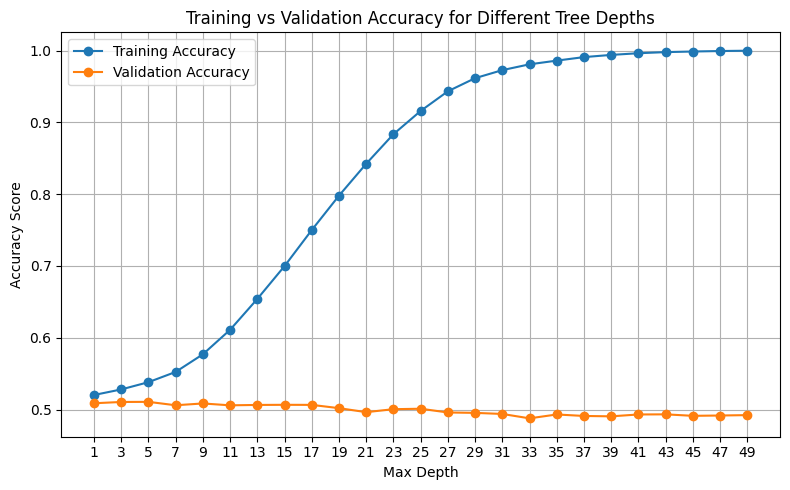

In [374]:
plt.figure(figsize=(8,5))

plt.plot(depth_hyperparams, training_acc, marker='o', label="Training Accuracy")
plt.plot(depth_hyperparams, validation_acc, marker='o', label="Validation Accuracy")


plt.xticks(depth_hyperparams)

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Training vs Validation Accuracy for Different Tree Depths")

plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.show()


<p style="color: yellow">TP, FP, TN, FN are purely relative to whatever you declare as the positive class.</p>

    - 1 is UP prediction
    - 0 is DOWN prediction
    - 1 is positive class
    - 0 is negative class



In [375]:
TN = cm[0][0]   #True Down  - When it should be down and model predicted down
FN = cm[1][0]   #False down - When it should be up but the model predicted down
FP = cm[0][1]   #False up   - When it should be down but the model predicted up
TP = cm[1][1]   #True UP    - When it should be up and the model predicted up

In [376]:
print(TN), print(TP), print(FN), print(FN)

559
894
491
491


(None, None, None, None)

#### Evaluate win rate

    Accuracy Measure

In [377]:
(TP+TN)/(TP+TN+FP+FN) 

np.float64(0.5211621233859397)

#### Evaluate the up Predictibility

In [378]:
TP/(TP+FP)

np.float64(0.5143843498273878)

#### Evaluate the up Predictibility

<p style="color: yellow; font-size: 20px">Recall</p>
    


In [379]:
TP/(TP+FN)  # Here we are essentially looking at - from all the True classes, how many True classes I predicted correctly

np.float64(0.6454873646209386)

<p style="color: yellow; font-size: 20px">Precision</p>

Precision is, for all of my predictions for a particular class, how many times I was right


In [380]:
TP/(TP+FP) # From all the times I predicted True/UP, How many were actually true/up

np.float64(0.5143843498273878)

#### Evaluate down predictability

<p style="color: yellow; font-size: 20px">Recall</p>


In [381]:
TN / (TN+FP) # Here we are essentially looking at - from all the False classes, how many false classes I predicted correctly

np.float64(0.398431931575196)

In [382]:
TN / (TN+FN)    # From as many times I predicted false, how many were actually false.

np.float64(0.5323809523809524)

###### **PRECISION**
###### "When I predict UP, how often am I actually right?"

```python
Precision = TP / (TP + FP)
```

**Out of all my UP predictions, how many were actually correct?**

- **Focus:** My predicted UP events (my actions)
- **Fear:** False Positives (wrongly predicting UP when it's actually DOWN)
- **High precision = When I say UP, you can trust me — but I might be missing opportunities**

---

###### **RECALL**
###### "How many actual UP moves did I successfully catch?"

```python
Recall = TP / (TP + FN)
```

**Out of all the real UP days, how many did my model correctly predict as UP?**

- **Focus:** The actual UP events (reality)
- **Fear:** False Negatives (missing UP days)
- **High recall = I catch most of the UP moves, even if I sometimes make wrong predictions**

---

###### **The Key Difference**

| | Precision | Recall |
|---|-----------|--------|
| **Perspective** | YOUR predictions | REALITY's events |
| **Denominator** | What YOU predicted | What ACTUALLY happened |
| **Question** | "Am I accurate?" | "Am I thorough?" |
| **Trading analogy** | "Hit rate of my signals" | "% of opportunities captured" |

---

###### **Trading Strategy Examples**

###### **High Precision, Low Recall Strategy**
- Very selective, only trades slam-dunk setups
- Few trades, but most are winners
- Good for: High transaction costs, limited capital, risk-averse

###### **Low Precision, High Recall Strategy**
- Casts a wide net, takes many signals
- Catches most moves, but many false alarms
- Good for: Low transaction costs, diversification, systematic execution

###### **Balanced Strategy**
- Optimizes F1-score (harmonic mean of precision and recall)
- Trades off some accuracy for better coverage
- Good for: Most real-world trading applications

---

###### **The Trade-off**

You can't maximize both simultaneously:

- ↑ Threshold → ↑ Precision, ↓ Recall (be picky)
- ↓ Threshold → ↓ Precision, ↑ Recall (be aggressive)

**The optimal balance depends on your strategy's economics.**


#### Directional Balance : Short Ratio

In [383]:
short_ratio = (FN+TN)/(FN+TN+FP+FP)
short_ratio

np.float64(0.38349159970781593)

#### Directional Balance: Long Ratio

In [384]:
long_ratio = (FP+TP)/(FN+TN+FP+FP)
long_ratio

np.float64(0.6347699050401753)

#### Directional Imbalance

In [385]:
short_ratio/long_ratio

np.float64(0.6041426927502878)

#### Evaluating Model's profitabilty (Out-of-sample)

In [386]:
df_test = X_test.copy()

In [387]:
df_test

,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
close_time,,,,,,
2025-11-01 14:29:59.999000+00:00,-0.222453,-0.275940,0.415131,-0.001807,0.001535,-0.002097
2025-11-01 14:44:59.999000+00:00,-0.071645,-0.150607,0.539078,0.001284,-0.001807,0.001535
2025-11-01 14:59:59.999000+00:00,-0.011959,-0.110862,0.577950,0.000452,0.001284,-0.001807
2025-11-01 15:14:59.999000+00:00,-0.003043,-0.120256,0.566539,-0.000043,0.000452,0.001284
2025-11-01 15:29:59.999000+00:00,0.234730,0.110993,0.802366,0.002418,-0.000043,0.000452
...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,0.362326,0.741975,0.876005,0.000886,-0.001771,0.004175
2025-11-30 14:29:59.999000+00:00,0.207416,0.630295,0.779183,-0.000951,0.000886,-0.001771
2025-11-30 14:44:59.999000+00:00,0.011687,0.475085,0.637924,-0.001403,-0.000951,0.000886


In [388]:
model.predict(X_test)

array([1, 1, 0, ..., 1, 1, 1], shape=(2788,))

In [389]:
model.predict_proba(X_test)

array([[0.47009233, 0.52990767],
       [0.49039645, 0.50960355],
       [0.51069431, 0.48930569],
       ...,
       [0.44051767, 0.55948233],
       [0.44051767, 0.55948233],
       [0.49039645, 0.50960355]], shape=(2788, 2))

In [390]:
df_test["y_pred_binary"] = model.predict(X_test)
df_test[["close_log_return", "close"]] = df_test_temp[["close_log_return", "close"]]

In [391]:
df_test

,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_pred_binary,close_log_return,close
close_time,,,,,,,,,
2025-11-01 14:29:59.999000+00:00,-0.222453,-0.275940,0.415131,-0.001807,0.001535,-0.002097,1,0.001284,109888.83
2025-11-01 14:44:59.999000+00:00,-0.071645,-0.150607,0.539078,0.001284,-0.001807,0.001535,1,0.000452,109938.55
2025-11-01 14:59:59.999000+00:00,-0.011959,-0.110862,0.577950,0.000452,0.001284,-0.001807,0,-0.000043,109933.85
2025-11-01 15:14:59.999000+00:00,-0.003043,-0.120256,0.566539,-0.000043,0.000452,0.001284,0,0.002418,110200.01
2025-11-01 15:29:59.999000+00:00,0.234730,0.110993,0.802366,0.002418,-0.000043,0.000452,1,-0.001271,110060.00
...,...,...,...,...,...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,0.362326,0.741975,0.876005,0.000886,-0.001771,0.004175,1,-0.000951,91682.73
2025-11-30 14:29:59.999000+00:00,0.207416,0.630295,0.779183,-0.000951,0.000886,-0.001771,0,-0.001403,91554.20
2025-11-30 14:44:59.999000+00:00,0.011687,0.475085,0.637924,-0.001403,-0.000951,0.000886,1,-0.002124,91359.92


#### Add Directional Signal

In [392]:
df_test["dir_signal"] = np.where(
    df_test["y_pred_binary"] == 1, 1, -1
)  # We have just replaced the zeroes with -1
df_test[["close_log_return", "y_pred_binary", "dir_signal"]]

,close_log_return,y_pred_binary,dir_signal
close_time,,,
2025-11-01 14:29:59.999000+00:00,0.001284,1,1
2025-11-01 14:44:59.999000+00:00,0.000452,1,1
2025-11-01 14:59:59.999000+00:00,-0.000043,0,-1
2025-11-01 15:14:59.999000+00:00,0.002418,0,-1
2025-11-01 15:29:59.999000+00:00,-0.001271,1,1
...,...,...,...
2025-11-30 14:14:59.999000+00:00,-0.000951,1,1
2025-11-30 14:29:59.999000+00:00,-0.001403,0,-1
2025-11-30 14:44:59.999000+00:00,-0.002124,1,1


#### Add trade log return

In [393]:
df_test["trade_log_return"] = df_test["dir_signal"] * df_test["close_log_return"]
df_test[
    [
        "close_log_return",
        "y_pred_binary",
        "dir_signal",
        "trade_log_return",
    ]
]

,close_log_return,y_pred_binary,dir_signal,trade_log_return
close_time,,,,
2025-11-01 14:29:59.999000+00:00,0.001284,1,1,0.001284
2025-11-01 14:44:59.999000+00:00,0.000452,1,1,0.000452
2025-11-01 14:59:59.999000+00:00,-0.000043,0,-1,0.000043
2025-11-01 15:14:59.999000+00:00,0.002418,0,-1,-0.002418
2025-11-01 15:29:59.999000+00:00,-0.001271,1,1,-0.001271
...,...,...,...,...
2025-11-30 14:14:59.999000+00:00,-0.000951,1,1,-0.000951
2025-11-30 14:29:59.999000+00:00,-0.001403,0,-1,0.001403
2025-11-30 14:44:59.999000+00:00,-0.002124,1,1,-0.002124


#### Compound growth returns (Log returns are time additive)

In [394]:
df_test["cum_trade_log_return"] = df_test["trade_log_return"].cumsum()

<Axes: xlabel='close_time'>

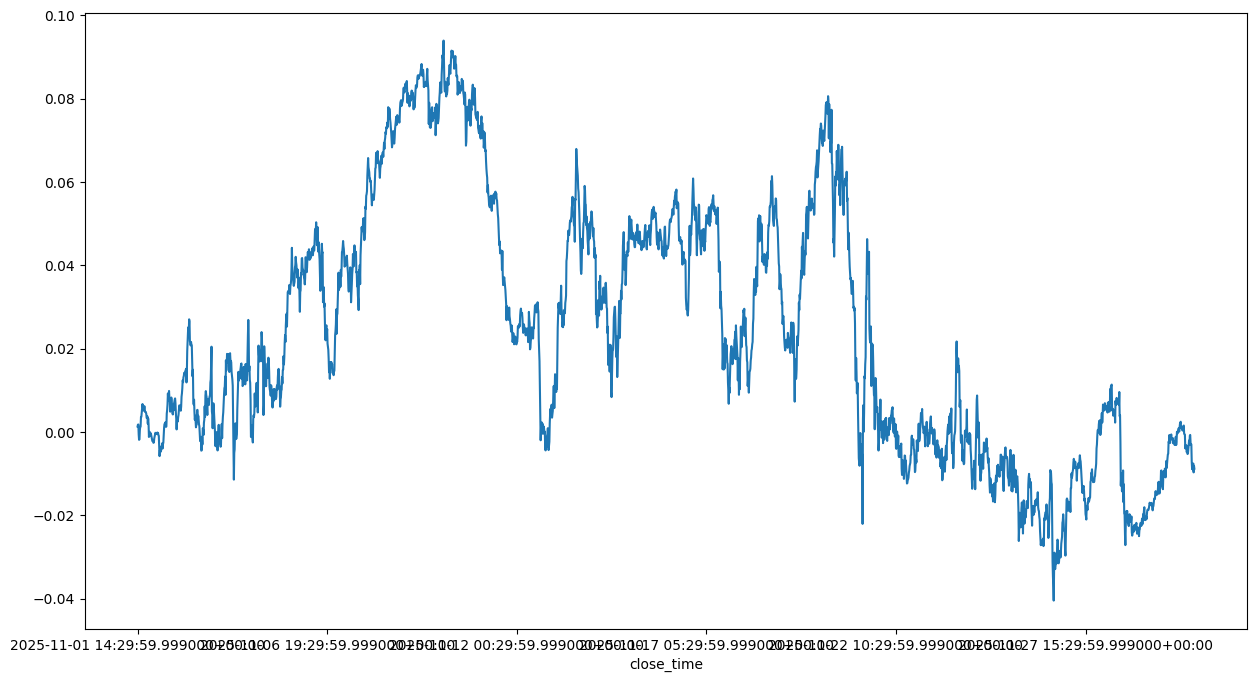

In [395]:
df_test["cum_trade_log_return"].plot(figsize=(15, 8))

<Axes: xlabel='close_time'>

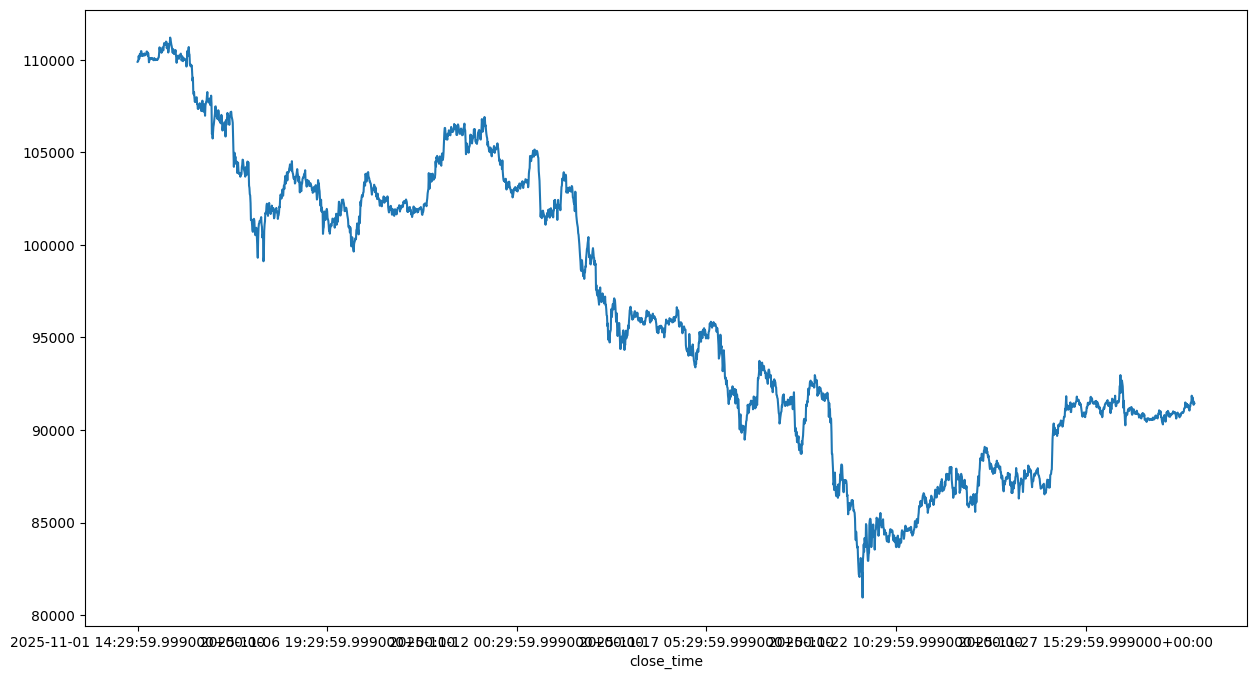

In [396]:
df_test["close"].plot(figsize=(15, 8))

#### Display Equity curve

In [397]:
intial_capital = 100

<Axes: xlabel='close_time'>

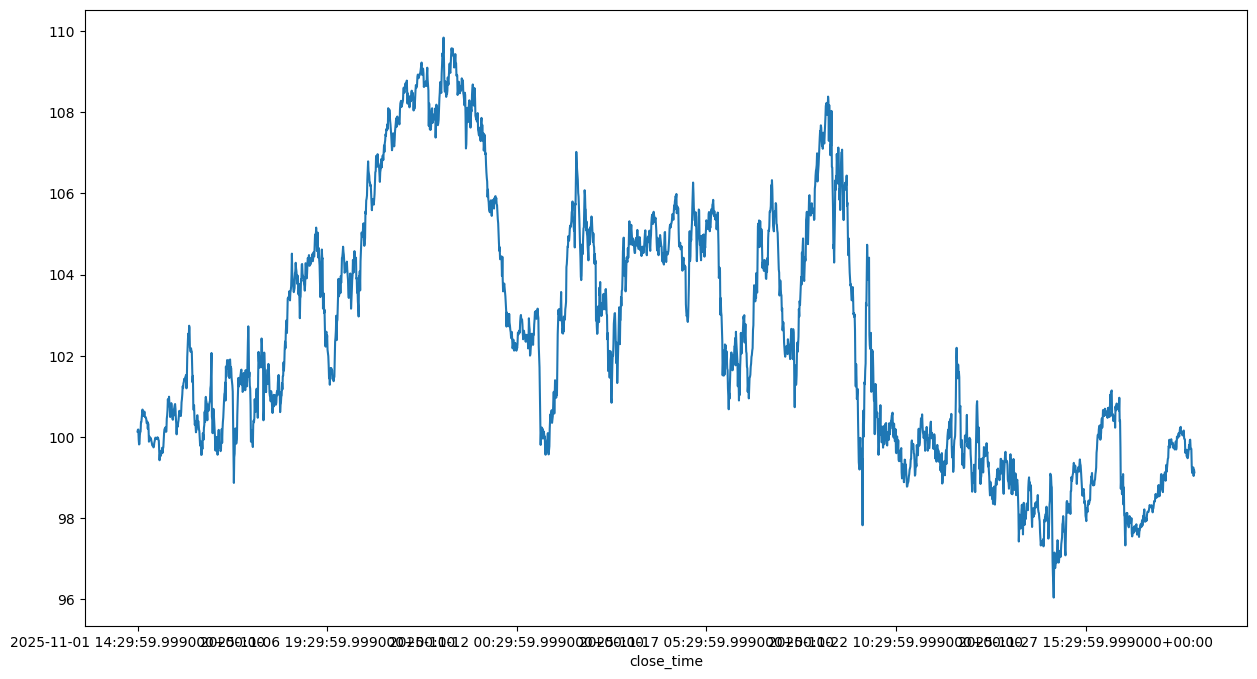

In [398]:
df_test["trade_gross_pnl"] = np.exp(df_test["cum_trade_log_return"]) * intial_capital
df_test["trade_gross_pnl"].plot(figsize=(15, 8))

#### Evaluate total compound return

In [399]:
total_compound_return = np.exp(df_test["trade_log_return"].sum())
total_compound_return

np.float64(0.9912047358818916)

#### Evaluate Gross PnL

In [400]:
total_compound_return * intial_capital

np.float64(99.12047358818916)